<a href="https://colab.research.google.com/github/thomaslu678/gee-test/blob/main/clean/1.2_airport_point_ee_lst_sine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2019 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Earth Engine Python API Colab Setup

This notebook demonstrates how to setup the Earth Engine Python API in Colab and provides several examples of how to print and visualize Earth Engine processed data.

## Import API and get credentials

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [4]:
import ee

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [5]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library. Replace with ID of GEE project
ee.Initialize(project='gee-481701')

## Test the API

Test the API by printing the elevation of Mount Everest.

In [6]:

# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729




```
# This is formatted as code
```

# Define Areas of Interest

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
import scipy.stats as stats
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Point
import requests

In [2]:
landsat_collections = {
    "L4": ("LANDSAT/LT04/C02/T1_L2", "ST_B6"),
    "L5": ("LANDSAT/LT05/C02/T1_L2", "ST_B6"),
    "L7": ("LANDSAT/LE07/C02/T1_L2", "ST_B6"),
    "L8": ("LANDSAT/LC08/C02/T1_L2", "ST_B10"),
    "L9": ("LANDSAT/LC09/C02/T1_L2", "ST_B10"),
}

In [7]:
lat, lon = 37.45866786333425, 126.4419675387768

point = ee.Geometry.Point(lon, lat)

# Functions

In [8]:
def mask_qa_pixel(img: ee.Image):
    # QA_PIXEL is the name of the fetched file that provides info
    # about pixel quality assurance
    qa = img.select("QA_PIXEL")

    # Fetch bits (0/1) describing if an environmental condition
    # is present
    cloud        = qa.bitwiseAnd(1 << 3).neq(0)
    cloud_shadow = qa.bitwiseAnd(1 << 4).neq(0)
    snow         = qa.bitwiseAnd(1 << 5).neq(0)
    cirrus       = qa.bitwiseAnd(1 << 2).neq(0)

    mask = (
        # Or condition for all bad conditions
        cloud
        .Or(cloud_shadow)
        .Or(snow)
        .Or(cirrus)

        # Not flips the conditions so any remaining pixels
        # have none of the conditions, and are "good" quality.
        .Not()
    )

    # Apply the mask to the input image
    return img.updateMask(mask)

In [9]:
def scale_lst(img, band):
    lst = (

        # Select the correct band, either ST_B6 or ST_B10
        img.select(band)
        .multiply(0.00341802)
        .add(149.0)
        .rename("LST_K")
    )

    # Add a new band to the original image, with the scaled LST
    return img.addBands(lst)

In [10]:
def extract_lst(collection_id, band, point, mission):
    col = (
        ee.ImageCollection(collection_id)
        .filterBounds(point)

        # Toggle this mask for more but less trustworthy data
        .map(mask_qa_pixel)

        # Apply the scaling of LST to every image, run server-side
        .map(lambda img: scale_lst(img, band))
    )

    def sample_image(img):
        sampled = img.select("LST_K").sample(
            # Sample exactly at the given point
            region=point,
            scale=30,
            numPixels=1,
            geometries=False
        )

        return ee.Feature(None, {
            "mission": mission,
            "image_id": img.id(),
            "time": ee.Date(img.get("system:time_start")).format("YYYY-MM-dd HH:mm:ss"),
            "lst_k": ee.Algorithms.If(
                sampled.size().gt(0),
                sampled.first().get("LST_K"),
                None
            )
        })

    return col.map(sample_image)

# Single coordinate data collection

In [11]:
features = []

for mission, (collection_id, band) in landsat_collections.items():
    fc = extract_lst(collection_id, band, point, mission)
    features.append(fc)

merged = ee.FeatureCollection(features).flatten()

In [12]:
results = merged.getInfo()

In [13]:
lst_records = []
times = []
for feature in results["features"]:
    data = feature["properties"]

    lst_records.append(data.get("lst_k", None))
    times.append(data["time"])

# Visualize

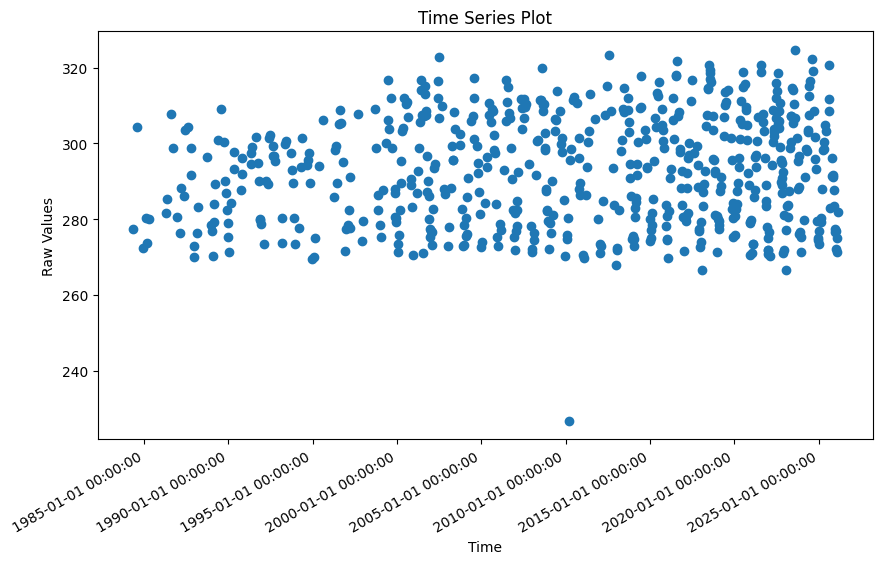

In [19]:
# 2. Convert time strings to datetime objects
# The format string '%Y-%m-%d %H:%M:%S' tells strptime how to parse the string
dates = [datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S') for dt_str in times]

# 3. Plot the data
fig, ax = plt.subplots(figsize=(10, 6)) # Create a figure and an axes object
ax.scatter(dates, lst_records, marker='o', linestyle='-')

# 4. Format the x-axis for better readability (optional but recommended for time series)
# Rotate and align the x-axis labels
fig.autofmt_xdate()
# Optionally, set a specific date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# 5. Add labels and a title
ax.set_xlabel("Time")
ax.set_ylabel("Raw Values")
ax.set_title("Time Series Plot")

# 6. Display the plot
plt.show()

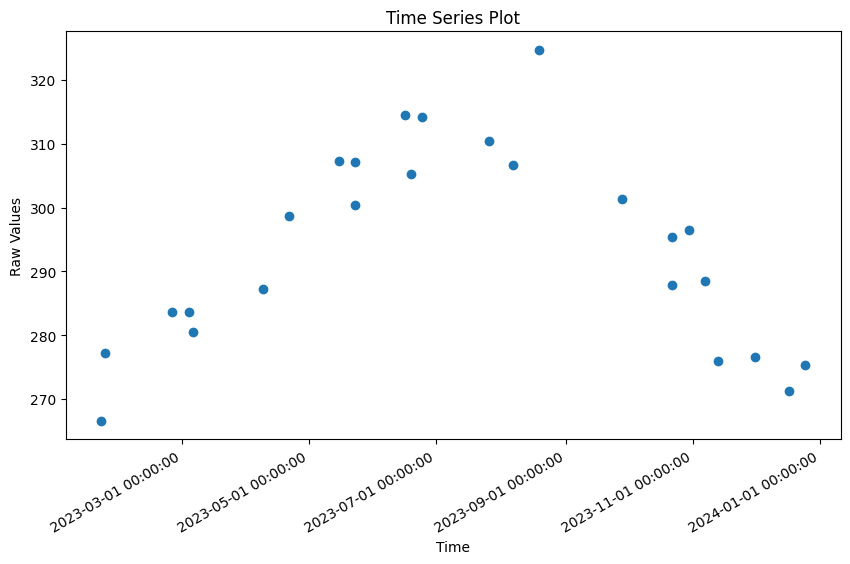

In [18]:
# 2. Convert time strings to datetime objects
# The format string '%Y-%m-%d %H:%M:%S' tells strptime how to parse the string
dates = [datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S') for dt_str in times]

start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

filtered_dates = []
filtered_records = []

for date, record in zip(dates, lst_records):
    if start_date <= date <= end_date:
        filtered_dates.append(date)
        filtered_records.append(record)

# 3. Plot the data
fig, ax = plt.subplots(figsize=(10, 6)) # Create a figure and an axes object
# ax.scatter(dates, lst_records, marker='o', linestyle='-')
ax.scatter(filtered_dates, filtered_records, marker='o', linestyle='-')

# 4. Format the x-axis for better readability (optional but recommended for time series)
# Rotate and align the x-axis labels
fig.autofmt_xdate()
# Optionally, set a specific date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# 5. Add labels and a title
ax.set_xlabel("Time")
ax.set_ylabel("Raw Values")
ax.set_title("Time Series Plot")

# 6. Display the plot
plt.show()

# Model data with sine fit

In [ ]:
def sine_model(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

In [ ]:
print(len(filtered_dates) == len(filtered_records))
print(filtered_dates)
print(filtered_records)

True
[datetime.datetime(2023, 2, 7, 0, 14, 17), datetime.datetime(2023, 2, 24, 0, 10, 21), datetime.datetime(2023, 3, 18, 0, 10, 17), datetime.datetime(2023, 4, 26, 0, 3, 25), datetime.datetime(2023, 7, 5, 23, 58, 15), datetime.datetime(2023, 7, 27, 23, 54, 8), datetime.datetime(2023, 10, 11, 23, 44, 25), datetime.datetime(2023, 11, 12, 23, 42, 51), datetime.datetime(2023, 1, 21, 0, 17, 45), datetime.datetime(2023, 3, 1, 0, 14, 55), datetime.datetime(2023, 3, 23, 0, 14, 37), datetime.datetime(2023, 4, 9, 0, 9, 15), datetime.datetime(2023, 4, 14, 0, 13, 24), datetime.datetime(2023, 5, 1, 0, 7, 25), datetime.datetime(2023, 5, 23, 0, 4, 55), datetime.datetime(2023, 6, 14, 0, 1, 51), datetime.datetime(2023, 6, 19, 0, 5, 34), datetime.datetime(2023, 10, 16, 23, 47, 22), datetime.datetime(2023, 10, 21, 23, 50, 16), datetime.datetime(2023, 1, 31, 2, 11, 26), datetime.datetime(2023, 2, 16, 2, 11, 18), datetime.datetime(2023, 3, 4, 2, 11, 5), datetime.datetime(2023, 3, 20, 2, 10, 57), datetime.

In [ ]:
dates = np.array(filtered_dates)
values = np.array(filtered_records, dtype=float)

mask = ~np.isnan(values)   # None → NaN when cast to float
dates_fit = dates[mask]
values_fit = values[mask]

t0 = dates_fit[0]
t = np.array(
    [(d - t0).total_seconds() / 86400 for d in dates_fit]
)

A_guess = (values_fit.max() - values_fit.min()) / 2
C_guess = values_fit.mean()
f_guess = 1 / 365      # yearly cycle (adjust if needed)
phi_guess = 0

p0 = [A_guess, f_guess, phi_guess, C_guess]

In [ ]:
print(type(dates_fit), type(values_fit), type(dates_fit[0]), type(values_fit[0]))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'datetime.datetime'> <class 'numpy.float64'>


In [ ]:
params, cov = curve_fit(
    sine_model,
    t,
    values_fit,
    p0=p0
)

A, f, phi, C = params
print(A, f, phi, C)

20.59402753294167 0.003019743433237978 -0.6636256059055977 295.01704355009593


# Graphing sine fit of single point

In [ ]:
def graph_sine_against_data(X, y, A, f, phi, C):

    dates = np.array(X)
    values = np.array(y, dtype=float)

    mask = ~np.isnan(values)   # None → NaN when cast to float
    dates_fit = dates[mask]
    values_fit = values[mask]

    t0 = dates_fit[0]

    # Dense grid of datetimes
    dates_dense = np.array([
        dates_fit.min() + timedelta(seconds=s)
        for s in np.linspace(
            0,
            (dates_fit.max() - dates_fit.min()).total_seconds(),
            1000
        )
    ])

    t_dense = np.array([(d - t0).total_seconds() / 86400 for d in dates_dense])
    y_fit = sine_model(t_dense, A, f, phi, C)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Original data
    ax.scatter(X, y,
              color='tab:blue', label='Data')

    # Fitted sine curve
    ax.plot(dates_dense, y_fit,
            color='tab:red', linewidth=2, label='Sine fit')

    # Formatting
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

    ax.set_xlabel("Time")
    ax.set_ylabel("Raw Values")
    ax.set_title("Time Series with Sine Fit")
    ax.legend()

    plt.show()

str -> datetime.datetime
float -> nonetype

In [ ]:
print((filtered_dates[0]))
print(type(filtered_records[2]))

2023-02-07 00:14:17
<class 'float'>


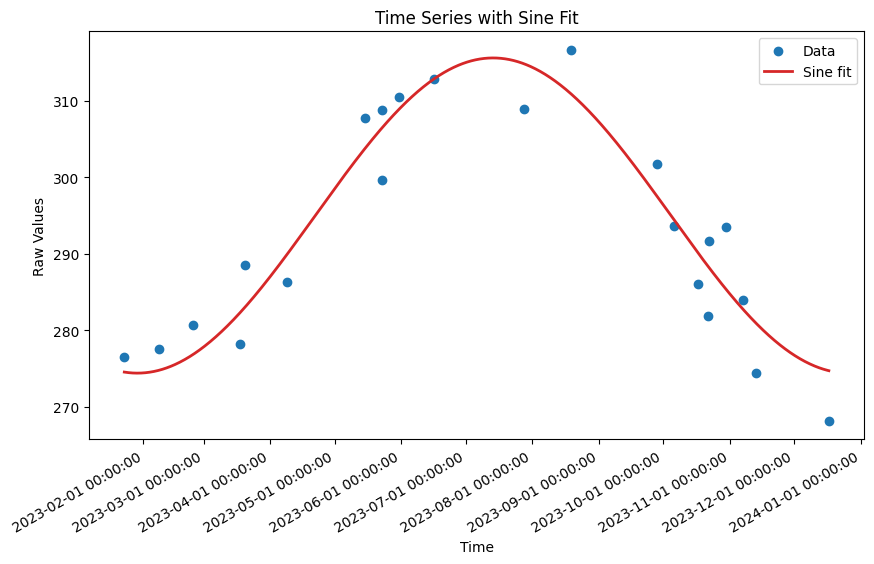

In [ ]:
graph_sine_against_data(filtered_dates, filtered_records, A, f, phi, C)

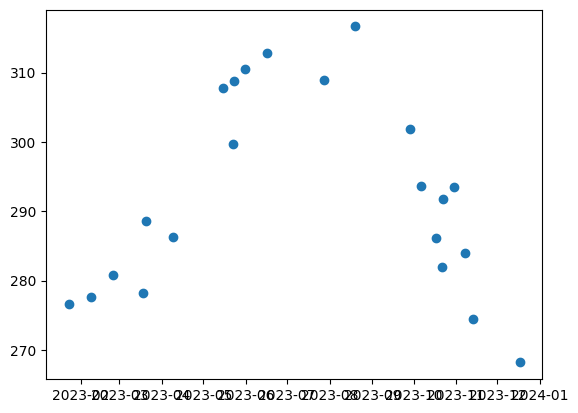

In [ ]:
plt.scatter(filtered_dates, filtered_records)
plt.show()

# Create One point DF


In [22]:
data = {'time': times, 'LST_K': lst_records}

# Create the DataFrame
df = pd.DataFrame(data)

In [23]:
df

,time,LST_K
0,1988-12-24 01:43:00,278.471180
1,1989-02-26 01:43:56,NaN
2,1989-03-14 01:43:50,NaN
3,1989-05-17 01:44:21,300.872883
4,1989-08-05 01:44:33,309.171835
...,...,...
1186,2025-12-14 02:11:24,NaN
1187,2025-12-30 02:11:28,277.428683
1188,2026-01-15 02:11:23,NaN
1189,2026-01-31 02:11:17,275.107848


In [24]:
df_cleaned = df.dropna(subset=['LST_K'])

In [25]:
df_cleaned

,time,LST_K
0,1988-12-24 01:43:00,278.471180
3,1989-05-17 01:44:21,300.872883
4,1989-08-05 01:44:33,309.171835
5,1991-11-15 01:21:41,280.019543
6,1991-12-01 01:20:53,279.677741
...,...,...
1184,2025-11-12 02:11:26,291.042657
1185,2025-11-28 02:11:24,283.444399
1187,2025-12-30 02:11:28,277.428683
1189,2026-01-31 02:11:17,275.107848


In [26]:
df_cleaned.to_csv('/content/sample_data/airport.csv', index=False)